## hetGPy `mcycle` example

This notebook shows a Gaussian Process Regression example with the classic `mcycle` data.

In [1]:
import sys
from hetgpy.hetGP import hetGP
from rpy2.robjects import r
from scipy.io import loadmat
from scipy.stats import norm
import numpy as np

# data
m = loadmat('../tests/data/mcycle.mat')
X = m['times'].reshape(-1,1)
Z = m['accel']
xgrid = np.linspace(0,60,301).reshape(-1,1)

# model
model = hetGP()
model.mleHetGP(
   X = X,
   Z = Z,
   lower = np.array([1]),
   upper = np.array([100]),
   covtype = "Gaussian",
   maxit = 5e3 
)

preds = model.predict(xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()

We can do the same thing in R and compare our results:

In [2]:
r('''
library(MASS)
library(hetGP)
X = as.matrix(mcycle$times)
Z = mcycle$accel
xgrid = as.matrix(seq(0,60,length.out = 301))
model = mleHetGP(X = X, Z = Z, 
            covtype = "Gaussian",
            lower = 1, upper = 100,maxit=2e2,
            settings = list(factr=10e7))
preds = predict(model,xgrid)
# predictive interval
preds$upper = qnorm(0.95, preds$mean, sqrt(preds$sd2 + preds$nugs))
preds$lower = qnorm(0.05, preds$mean, sqrt(preds$sd2 + preds$nugs)) 
''')
r_preds = dict(mean = np.array(r('preds$mean')),
               upper = np.array(r('preds$upper')),
               lower = np.array(r('preds$lower'))
)

And then we can plot:

Text(0, 0.5, 'accel (g)')

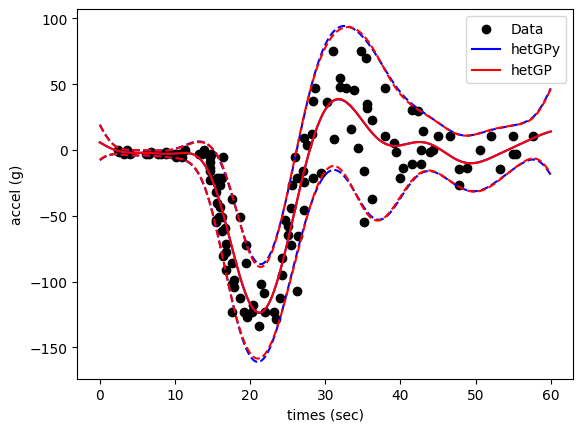

In [3]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(nrows=1,ncols=1)

# data
ax.scatter(X.squeeze(),Z,color='black',label='Data')

# hetGPy
xs = xgrid.squeeze()
ax.plot(xs,preds['mean'],color='blue',label='hetGPy')
ax.plot(xs,preds['upper'],color='blue',linestyle='dashed')
ax.plot(xs,preds['lower'],color='blue',linestyle='dashed')

# hetGP
ax.plot(xs,r_preds['mean'],color='red',label='hetGP')
ax.plot(xs,r_preds['upper'],color='red',linestyle='dashed')
ax.plot(xs,r_preds['lower'],color='red',linestyle='dashed')

ax.legend()
ax.set_xlabel('times (sec)')
ax.set_ylabel('accel (g)')